In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

In [17]:
# Create model for u
u_model = Sequential()
u_model.add(Dense(100, input_shape=[2,], activation='selu'))
u_model.add(Dense(100, activation='selu'))
u_model.add(Dense(100, activation='selu'))
u_model.add(Dense(100, activation='selu'))
u_model.add(Dense(100, activation='selu'))
u_model.add(Dense(100, activation='selu'))
u_model.add(Flatten())
u_model.add(Dense(1))

# Create model for lambda, lambda already defined :(
lamda_model = Sequential()
lamda_model.add(Dense(100, input_shape=[2,], activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Flatten())
lamda_model.add(Dense(1))

In [4]:
def theta2cart(theta, r): # converts random thetas and fixed r into x and y coordinates
    x_out = tf.math.multiply(r, tf.math.cos(theta)) # x = 4cos(theta_in)
    y_out = tf.math.multiply(r, tf.math.sin(theta)) # y = 4sin(theta_in)
    
    pts = tf.transpose(tf.stack([x_out,y_out],0))
    return pts

In [29]:
def out_bnd_fn(theta_out): # f(4,theta) = 4sin(5theta)
    f_true = tf.transpose(tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5,theta_out))))
    return f_true

In [60]:
def u_loss(u_model, lamda_model, int_pts, theta_in, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
    
# Find loss for interior points ###########################################################################
    with tf.GradientTape() as t:
        t.watch(int_pts)
        u = u_model(int_pts)
        #print('g = ', g)
    grad_u = t.gradient(u, int_pts) 
    dirichlet_energy = tf.math.reduce_mean(tf.math.square(grad_u))
    
    # Find loss for lagrange  term #########################################################################    
    out_bnd_pts = theta2cart(theta_out,4)
    in_bnd_pts = theta2cart(theta_in,2)
            
    # lambda * (u(x)-f(x)) for outer boundary condition
    out_lagrangian = lamda_model(out_bnd_pts) * (u_model(out_bnd_pts) - out_bnd_fn(out_bnd_pts))
    # lambda * (u(x)-0) for inner boundary condition
    in_lagrangian = lamda_model(in_bnd_pts) * u_model(in_bnd_pts)
    
    lagrangian = tf.concat([out_lagrangian, in_lagrangian],0) 
    lagrange_loss = -1 * tf.math.reduce_sum(lagrangian)

# Total loss ##############################################################################################
    loss = tf.math.add(dirichlet_energy, lagrange_loss)
    return loss

# lambda loss function
def lamda_loss(u_model, lamda_model, theta_out, theta_in): # x needs to be just on boundary
    
    out_bnd_pts = theta2cart(theta_out,4)
    in_bnd_pts = theta2cart(theta_in,2)
    
    print("u_model(out_bnd_pts) shape: ", tf.shape(u_model(out_bnd_pts)))
    print("out_bnd_fn(out_bnd_pts) shape: ", tf.shape(out_bnd_fn(out_bnd_pts)))
    
    # lambda * (u(x)-f(x)) for outer boundary condition
    f_out_bnd = tf.transpose(tf.squeeze(out_bnd_fn(out_bnd_pts)))
    print("f_out_bnd shape = ", tf.shape(f_out_bnd))
    
    out_lagrangian = lamda_model(out_bnd_pts) * (u_model(out_bnd_pts) - f_out_bnd)

    print("out_lagrangian shape: ", tf.shape(out_lagrangian))
    # lambda * (u(x)-0) for inner boundary condition
    in_lagrangian = lamda_model(in_bnd_pts) * u_model(in_bnd_pts)
    print("in_lagrangian shape: ", tf.shape(in_lagrangian))
    
    lagrangian = tf.concat([out_lagrangian, in_lagrangian],0) 
    lagrange_loss = -1 * tf.math.reduce_sum(lagrangian)
    return loss

In [61]:
# Train u network
def train_u(epochs):
# Define training parameters ##############################################################################    
    print('Training u...')
    
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    int_pts_size = 100 # Number of interior points to sample each iteration
    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration


    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
# Sample interior points ##################################################################################
            r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
                tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1,int_pts_size], minval=0, maxval=1))))
            theta_int = tf.random.uniform([1,int_pts_size], minval=0, maxval=2*np.pi)
            int_pts = theta2cart(theta_int, r_int)
    
# Sample inner bound thetas (converted to points in loss function) ########################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas (converted to points in loss function) ########################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = u_loss(u_model, lamda_model, int_pts, theta_in, theta_out) # Loss
            grads = t.gradient(u_loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch
###########################################################################################################        
        
# Train lambda network
def train_lamda(epochs):
# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for iteration in range(iterations_per_epoch):
# Sample inner bound thetas (converted to points in loss function) ########################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas (converted to points in loss function) ########################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = lamda_loss(u_model, lamda_model, theta_in, theta_out) # Loss
            grads = t.gradient(lamda_loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch
###########################################################################################################

def training_loop(total_iterations, u_epochs, lamda_epochs):
    for i in range(total_iterations):
        print("Iteration {:03d}:".format(i))
        
        print("Training lambda...")
        train_lamda(lamda_epochs)
                
        print("Training u...")
        train_u(u_epochs)
        

In [62]:
train_lamda(1)
# training_loop(5,20,1)

u_model(out_bnd_pts) shape:  tf.Tensor([1000    1], shape=(2,), dtype=int32)
out_bnd_fn(out_bnd_pts) shape:  tf.Tensor([   2    1 1000], shape=(3,), dtype=int32)
f_out_bnd shape =  tf.Tensor([1000    2], shape=(2,), dtype=int32)
out_lagrangian shape:  tf.Tensor([1000    2], shape=(2,), dtype=int32)
in_lagrangian shape:  tf.Tensor([1000    1], shape=(2,), dtype=int32)


InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1000,2] vs. shape[1] = [1000,1] [Op:ConcatV2] name: concat

In [18]:
# Generate test points to plot ############################################################################
in_bnd_pts_size = 10000 # Number of inner boundary points to sample 
out_bnd_pts_size = 10000 # Number of outer boundary points to sample 
int_pts_size = 10000 # Number of interior points to sample

# Sample interior points ##################################################################################
r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
    tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1, int_pts_size], minval = 0, maxval=1))))
theta_int = tf.random.uniform([1, int_pts_size], minval=0, maxval=2*np.pi)
# Convert to cartestian
int_pts = theta2cart(theta_int, r_int)

# Sample inner boundary points ############################################################################
theta_in = tf.random.uniform([1, in_bnd_pts_size], minval=0, maxval=2*np.pi)
in_bnd_pts = theta2cart(theta_in, 2)

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
out_bnd_pts = theta2cart(theta_out, 4)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.concat([int_pts, in_bnd_pts, out_bnd_pts],0)
# print(test_pts)
print("test_pts_shape: ", test_pts.shape)

z = u_model(test_pts)
print("z shape: ", tf.shape(z))

test_pts_shape:  (30000, 1, 2)
z shape:  tf.Tensor([30000     1], shape=(2,), dtype=int32)


(30000,)
(30000,)
(30000,)


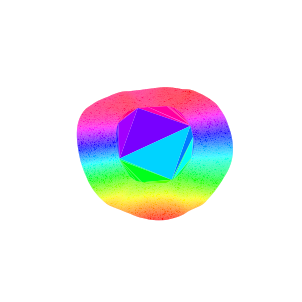

In [19]:
# Plot ####################################################################################################

fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

xmin = -4
xmax = 4
ymin = -4
ymax = 4
zmin = -4
zmax = 4

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.hsv)
ax.view_init(30, 20)
ax.grid(b=None)
ax.axis('off')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), zlim=(zmin,zmax))
plt.show()

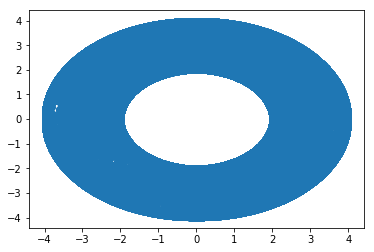

In [20]:
# Check sample points
plt.scatter(X,Y)
plt.show()

In [23]:
# Alternative Plotting ####################################################################################
u = np.linspace(0, 2*np.pi, 100)
# print(u.shape)
v = np.linspace(2, 4, 100)

u,v = np.meshgrid(u,v)
u = u.flatten()
# print(u.shape)
v = v.flatten()

x = v*np.cos(u)
y = v*np.sin(u)

U = tf.convert_to_tensor(u)
V = tf.convert_to_tensor(v)

sample_pts = theta2cart(U,V)

Z = u_model(sample_pts)
# print("Z_shape: ", test_pts.shape)

z = Z[0:,0].numpy()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig = ff.create_trisurf(x=x, y=y, z=z, simplices=simplices,title="Laplace DVM (Lagrangian)", plot_edges=False, colormap="Portland")
fig.show()

In [24]:
# Alternative Plotting ####################################################################################
u = np.linspace(0, 2*np.pi, 100)
# print(u.shape)
v = np.linspace(2, 4, 100)

u,v = np.meshgrid(u,v)
u = u.flatten()
# print(u.shape)
v = v.flatten()

x = v*np.cos(u)
y = v*np.sin(u)

U = tf.convert_to_tensor(u)
V = tf.convert_to_tensor(v)

sample_pts = theta2cart(U,V)

Z = lamda_model(sample_pts)
# print("Z_shape: ", test_pts.shape)

z = Z[0:,0].numpy()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig = ff.create_trisurf(x=x, y=y, z=z, simplices=simplices,title="Lambda", plot_edges=False, colormap="Portland")
fig.show()